# Model Development and Training

In this Jupyter Notebook, you will develop and train the model.

In [481]:
### Importing...
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import missingno as msno
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


### Connecting to PostgreSQL to access database

In [482]:
# reads the whole API
conn2 = ps.connect(dbname = "postgres",
                   user = "postgres",
                   password = "postgres",
                   host = "localhost",
                   port = "5432")

In [483]:
# connect area table
area_sql = """select * 
fROM public.area"""

# connect farm table
farm_sql = """select * 
fROM public.farm"""

# connect product table
product_sql = """select * 
fROM public.product"""

# connect sale_order table
so_sql = """select * 
fROM public.sale_order"""

# connect sale_order_item table
soi_sql = """select * 
fROM public.sale_order_item"""

# connect feedback table
feedback_sql = """select *
fROM public.feedback"""

# connect product_clicks table
product_clicks_sql = """select *
fROM public.product_clicks"""

# connect user_session table
user_session_sql = """select *
fROM public.user_session"""

In [484]:
# read area table
area_df = sqlio.read_sql_query(area_sql, conn2)

# read farm table
farm_df = sqlio.read_sql_query(farm_sql, conn2)

# read product table
product_df = sqlio.read_sql_query(product_sql, conn2)

# read sale_order table
so_df = sqlio.read_sql_query(so_sql, conn2)

# read sale_order_item table
soi_df = sqlio.read_sql_query(soi_sql, conn2)

# read feedback table
feedback_df = sqlio.read_sql_query(feedback_sql, conn2)

# read product_clicks table
product_clicks_df = sqlio.read_sql_query(product_clicks_sql, conn2)

# read user_session table
user_session_df = sqlio.read_sql_query(user_session_sql, conn2)

C:\Users\user\AppData\Local\Temp\ipykernel_20448\440608200.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  area_df = sqlio.read_sql_query(area_sql, conn2)
C:\Users\user\AppData\Local\Temp\ipykernel_20448\440608200.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  farm_df = sqlio.read_sql_query(farm_sql, conn2)
C:\Users\user\AppData\Local\Temp\ipykernel_20448\440608200.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  product_df = sqlio.read_sql_query(product_sql, conn2)
C:\Users\user\AppData\Local\Temp\ipykernel_204

In [485]:
# show the first 5 rows of the area_df DataFrame
area_df.head()

,id,name,level_0,level_1,level_2,level_3,level_3_latitude,level_3_longitude,level_4,level_4_latitude,level_4_longitude
0,ID1101032013,"Ujung Pasir, Kluet Selatan, Aceh Selatan, Aceh",Indonesia,Aceh,Aceh Selatan,Kluet Selatan,3.051660,97.459770,Ujung Pasir,3.079105,97.328659
1,ID1101142007,"Pucuk Lembang, Kluet Timur, Aceh Selatan, Aceh",Indonesia,Aceh,Aceh Selatan,Kluet Timur,3.171040,97.459770,Pucuk Lembang,3.161074,97.488838
2,ID1102022015,"Suka Maju, Lawe Sigala-Gala, Aceh Tenggara, Aceh",Indonesia,Aceh,Aceh Tenggara,Lawe Sigala-Gala,3.356980,97.926600,Suka Maju,3.356778,97.932930
3,ID1102032026,"Terutung Seperai, Bambel, Aceh Tenggara, Aceh",Indonesia,Aceh,Aceh Tenggara,Bambel,3.457160,97.904820,Terutung Seperai,3.454491,97.833214
4,ID1205012002,"Lau Damak, Bahorok, Langkat, Sumatera Utara",Indonesia,Sumatera Utara,Langkat,Bahorok,3.465968,98.046516,Lau Damak,3.472219,98.098335


In [486]:
# show the first 5 rows of the farm_df DataFrame
farm_df.head()

,id,owner_id,area_id,latitude,longitude,area_hectare,planted_year,planted_month,palm_trees_per_hectare,soil_type,seed_type
0,f02bcded-3b72-43b9-8f14-f7687c4afbd9,145f7e51-c0e9-4dd3-b730-8dd03ee98c3a,ID1223052007,NaN,NaN,1.00,2015,4,125.0,Mineral,None
1,c18238d1-11ae-43eb-aa16-b9c2d14616dd,f6592c39-68a7-41e3-af84-b79d9a1a5540,ID1223052007,NaN,NaN,1.00,2025,4,125.0,Mineral,None
2,b519bade-60bf-4781-ba45-6e4803b005c6,4984b691-ed21-4188-b107-cde9bbe65d7f,ID1223052007,NaN,NaN,1.00,2025,4,125.0,Mineral,None
3,72f4944b-4ca5-40c6-9521-532886a91035,2f8ff664-d15f-44d9-9011-842f646e803f,ID1223052007,NaN,NaN,1.00,2016,4,125.0,Mineral,None
4,e355222d-1ec6-4a7b-9c0f-516a469b7f91,65df540b-c162-40e5-b806-cef9bd0139d7,ID1223052006,NaN,NaN,1000.25,2010,4,130.0,Mineral,None


In [487]:
# show the first 5 rows of the product_df DataFrame
product_df.head()

,id,sku,type,unit_of_measurement,name,price,description
0,beb17fe4-5d92-4738-adaa-2d62ffb83516,101110503802,GOODS,kg,Urea Nitrea 46% N 50kg - Granul,356357.0,<p>Urea Nitrea 46% N 50kg Granul</p>
1,b67588d2-e8fe-4ee4-9931-e9d18241d04c,202310305001,GOODS,kg,PRIMASTAR 300/100 SL 5 liter,230000.0,"<h2 class=""ql-align-justify""><span style=""background-color: rgb(255, 255, 255); color: rgb(0, 0, 0);"">PRIMASTAR 300/100 SL : Herbisida sistemik purna tumbuh berbentuk larutan dalam air untuk mengendalikan gulma berdaun lebar dan gulma golongan rumput pada pertanaman kelapa sawit (TBM)</span></h2><p><br></p><h2><span style=""background-color: rgb(255, 255, 255); color: rgb(0, 0, 0);"">Bahan Aktif : Isopropil Amina Glifosat 300 g/l + 2,4-D Dimetil Amina 100 g/l</span></h2><p><br></p><h2 class=""ql-align-center""><span style=""background-color: rgb(8, 18, 138); color: rgb(255, 255, 255);"">Cara & Waktu Aplikasi</span></h2><p><br></p><h2><span style=""background-color: rgb(255, 255, 255); color: rgb(0, 0, 0);"">Penyemprotan volume tinggi dengan volume 400 - 600 l/ha. Aplikasi dimulai saat gulma tumbuh subur dan tidak turun hujan 4 - 6 jam setelah penyemprotan. Apabila belum jelas hubungi petugas pertanian yang berwenang</span></h2><p><br></p>"
2,c5e57af4-0df9-4e2b-87e4-9024b8e6cf53,202310304901,GOODS,kg,DMA 6 825 SL 400ml,97000.0,"<p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">DMA6 825 SL</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Berat bersih: 400ml</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Bahan aktif: 2,4-D dimetil amina (setara dengan 2,4-D: 686 g/l) : 825 g/l</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Produksi : Corteva Agriscience</span></p><p><br></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">DMA6 825 SL</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Herbisida sistemik selektif purna tumbuh yang berbentuk larutan dalam air berwarna coklat muda,sangat efektif untuk mengendalikan gulma di pertanaman padi, karet, teh dan tebu.</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Herbisida ini sudah tidak diragukan untuk tanaman padi sawah. yang berguna menberantas gulma daun lebar (Broadleaf) and teki tekian di sawah. juga sangat bagus untuk campuran ke glyphosate dan paraquat.</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Dapat digunakan pada tanaman: karet, padi, tebu, teh</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Herbisida sistemik purna tumbuh berbentuk larutan dalam air.</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Dosis :</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">– Karet (Gulma Berdaun Lebar) : 1,5 – 3 l/Ha</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Waktu Penyemprotan : Pada saat gulma masih muda dan aktif pertumbuhannya</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">– Teh (Gulma Berdaun Lebar) : 1 – 1,5 l/Ha</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Waktu Penyemprotan : Pada saat gulma masih muda dan aktif pertumbuhannya</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">– Tebu (Gulma Berdaun Lebar) : 1 – 2 l/Ha</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Waktu Penyemprotan : Segera setelah tanam, atau 3 hari setelah tanam atau 14 hari setelah tanam</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">– Padi (Gulma Berdaun Lebar dan Teki

In [488]:
# show the first 5 rows of the so_df DataFrame
so_df.head()

,id,user_id,total_item_price,created_at_utc0
0,74be876e-f74b-4633-b403-e07fa9861943,9c605d36-9c37-4f1e-bac1-c87146fae1f0,102000000.0,1744879059936
1,911a4c25-75d1-4f67-9a8a-40cb365b4cf0,49ad56f8-8d32-408f-9f88-36cad5310680,433200.0,1744875110464
2,e5819416-6b56-4337-9271-dc2c701ac7bd,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061
3,61e68625-9e6a-435d-9bdd-6c2187ca1817,49ad56f8-8d32-408f-9f88-36cad5310680,433200.0,1744868860328
4,667698fd-6694-4b97-b7f3-e993f1cd7756,231e825c-16af-4695-bda8-91deb60777e5,50000.0,1744859221323


In [489]:
# show the first 5 rows of the soi_df DataFrame
soi_df.head()

,id,sale_order_id,product_id,quantity,price,clicked_from_recommendation,click_timestamp
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200,326000.0,False,None
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,None
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,None
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,None
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,None


In [490]:
# show the first 5 rows of the feedback_df DataFrame
feedback_df.head()

,feedback_id,sales_order_id,rating,comment
0,e4a7c3f1-2d9b-486e-90c5-1d6f8b7a5e3c,d20a9066-aed8-4082-98e6-7abc62b7bf78,5,Exceeded expectations in every way!
1,9b8c7d6e-5f4a-43b2-a1c0-d9e8f7a6b5c4,ba87bf4a-4099-4101-84fb-ef0248fdf987,4,"Very good service, would recommend."
2,2f3e4d5c-6b7a-4897-a6b5-c4d3e2f1a0b9,e465e104-5248-4bd6-8650-4388f1a37e0f,3,"Average experience, nothing special."
3,a8b7c6d5-e4f3-4a2b-91c0-d9e8f7a6b5c4,86496962-031e-4f39-a78c-dd907bcd7322,5,"Absolutely perfect, couldn't ask for more."
4,5c6d7e8f-9a0b-4c1d-82e3-f4a5b6c7d8e9,a1c52691-d8de-4613-84f0-c78abf103cac,2,"Disappointed with quality, needs improvement."


In [491]:
# show the first 5 rows of the product_clicks_df DataFrame
product_clicks_df.head()

,prodct_clicks_id,product_id,timestamp
0,b9c8d7e6-f5a4-4b3c-92d1-e0f9a8b7c6d5,0bd2430a-6613-442a-9d5a-11d64cb095ae,2025/05/01 08:05:00
1,3a4b5c6d-7e8f-4a0b-81c2-d3e4f5a6b7c8,1033503b-8faa-4d5c-97c2-50bb19fbb897,2025/03/17 14:32:45
2,e0f1a2b3-c4d5-4e6f-87a8-b9c0d1e2f3a4,1af0394e-3aea-42b4-8698-b6832e35f8ce,2025/07/29 09:18:22
3,7a8b9c0d-1e2f-4a3b-84c5-d6e7f8a9b0c1,2485b082-5258-44c1-b6aa-983387d540a7,2025/04/12 16:45:37
4,1e2f3a4b-5c6d-47e8-8f9a-0b1c2d3e4f5a,2b8fe2f0-5d07-459c-8781-22305a61980a,2025/06/05 11:09:54


In [492]:
# show the first 5 rows of the user_session_df DataFrame
user_session_df.head()

,user_session_id,user_id,session_start,session_end
0,d20a9066-aed8-4082-98e6-7abc62b7bf78,05ebeca1-5a73-46ec-88fc-323b29d468cc,2025/03/15 09:23:17,2025/03/15 10:47:32
1,5f3c8b1a-6d24-4ea7-b519-f32c0e48d92c,7a341d40-7166-46d4-b37f-be9a9ecec7f7,2025/04/22 14:05:39,2025/04/22 15:38:51
2,a7f9e031-2bcd-4568-9174-8d26e0b7c943,34e01958-7a5d-4016-bb9a-e36d87ed3bf6,2025/01/08 18:32:45,2025/01/08 19:15:12
3,16eb7d42-5c9a-4f83-b0e5-3a192d4c6b87,917278db-9719-4988-a151-237f4fc74b9d,2025/07/19 08:17:23,2025/07/19 11:03:45
4,c8b53e9f-471d-4a20-9c8e-0b7d2f961a45,b93b8e2b-ffa7-4e29-bbf1-c90cce4c0962,2025/02/28 16:45:10,2025/02/28 17:22:38


In [493]:
# show shape of the area_df DataFrame
area_df.shape

(46, 11)

In [494]:
# show shape of the farm_df DataFrame
farm_df.shape

(100, 11)

In [495]:
# show shape of the product_df DataFrame
product_df.shape

(41, 7)

In [496]:
# show shape of the so_df DataFrame 
so_df.shape

(100, 4)

In [497]:
# show shape of the soi_df DataFrame
soi_df.shape

(116, 7)

In [498]:
# show shape of the feedback_df DataFrame
feedback_df.shape

(41, 4)

In [499]:
# show shape of the product_clicks_df DataFrame
product_clicks_df.shape

(41, 3)

In [500]:
# show shape of the user_session_df DataFrame
user_session_df.shape

(41, 4)

In [501]:
# show data types of the area_df DataFrame
area_df.dtypes

id                    object
name                  object
level_0               object
level_1               object
level_2               object
level_3               object
level_3_latitude     float64
level_3_longitude    float64
level_4               object
level_4_latitude     float64
level_4_longitude    float64
dtype: object

In [502]:
# show data types of the farm_df DataFrame
farm_df.dtypes

id                         object
owner_id                   object
area_id                    object
latitude                  float64
longitude                 float64
area_hectare              float64
planted_year                int64
planted_month               int64
palm_trees_per_hectare    float64
soil_type                  object
seed_type                  object
dtype: object

In [503]:
# show data types of the product_df DataFrame
product_df.dtypes

id                      object
sku                     object
type                    object
unit_of_measurement     object
name                    object
price                  float64
description             object
dtype: object

In [504]:
# show data types of the so_df DataFrame
so_df.dtypes

id                   object
user_id              object
total_item_price    float64
created_at_utc0       int64
dtype: object

In [505]:
# show data types of the soi_df DataFrame
soi_df.dtypes

id                              object
sale_order_id                   object
product_id                      object
quantity                         int64
price                          float64
clicked_from_recommendation       bool
click_timestamp                 object
dtype: object

In [506]:
# show data types of the feedback_df DataFrame
feedback_df.dtypes

feedback_id       object
sales_order_id    object
rating            object
comment           object
dtype: object

In [507]:
# show data types of the product_clicks_df DataFrame
product_clicks_df.dtypes

prodct_clicks_id    object
product_id          object
timestamp           object
dtype: object

In [508]:
# show data types of the user_session_df DataFrame
user_session_df.dtypes

user_session_id    object
user_id            object
session_start      object
session_end        object
dtype: object

In [509]:
area_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 46 non-null     object 
 1   name               46 non-null     object 
 2   level_0            46 non-null     object 
 3   level_1            46 non-null     object 
 4   level_2            46 non-null     object 
 5   level_3            46 non-null     object 
 6   level_3_latitude   46 non-null     float64
 7   level_3_longitude  46 non-null     float64
 8   level_4            46 non-null     object 
 9   level_4_latitude   46 non-null     float64
 10  level_4_longitude  46 non-null     float64
dtypes: float64(4), object(7)
memory usage: 4.1+ KB


In [510]:
farm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      100 non-null    object 
 1   owner_id                100 non-null    object 
 2   area_id                 100 non-null    object 
 3   latitude                2 non-null      float64
 4   longitude               2 non-null      float64
 5   area_hectare            100 non-null    float64
 6   planted_year            100 non-null    int64  
 7   planted_month           100 non-null    int64  
 8   palm_trees_per_hectare  48 non-null     float64
 9   soil_type               100 non-null    object 
 10  seed_type               28 non-null     object 
dtypes: float64(4), int64(2), object(5)
memory usage: 8.7+ KB


In [511]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   41 non-null     object 
 1   sku                  41 non-null     object 
 2   type                 41 non-null     object 
 3   unit_of_measurement  41 non-null     object 
 4   name                 41 non-null     object 
 5   price                41 non-null     float64
 6   description          41 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.4+ KB


In [512]:
so_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                100 non-null    object 
 1   user_id           100 non-null    object 
 2   total_item_price  100 non-null    float64
 3   created_at_utc0   100 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.3+ KB


In [513]:
soi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           116 non-null    object 
 1   sale_order_id                116 non-null    object 
 2   product_id                   116 non-null    object 
 3   quantity                     116 non-null    int64  
 4   price                        116 non-null    float64
 5   clicked_from_recommendation  116 non-null    bool   
 6   click_timestamp              0 non-null      object 
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 5.7+ KB


In [514]:
feedback_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   feedback_id     41 non-null     object
 1   sales_order_id  41 non-null     object
 2   rating          41 non-null     object
 3   comment         41 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


In [515]:
product_clicks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   prodct_clicks_id  41 non-null     object
 1   product_id        41 non-null     object
 2   timestamp         41 non-null     object
dtypes: object(3)
memory usage: 1.1+ KB


In [516]:
user_session_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_session_id  41 non-null     object
 1   user_id          41 non-null     object
 2   session_start    41 non-null     object
 3   session_end      41 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


In [517]:
# show the statistics of the area_df DataFrame
area_df.describe()

,level_3_latitude,level_3_longitude,level_4_latitude,level_4_longitude
count,46.000000,46.000000,46.000000,46.000000
mean,0.356527,101.338789,0.359234,101.341713
std,3.117636,3.299132,3.118584,3.295200
min,-7.097770,97.459770,-7.129365,97.328659
25%,-1.641203,98.759658,-1.612830,98.774652
50%,1.689045,100.069371,1.625296,100.112301
75%,2.956138,102.949610,2.977077,102.942095
max,3.805560,113.846580,3.847265,113.861448


In [518]:
# show the statistics of the farm_df DataFrame
farm_df.describe()  

,latitude,longitude,area_hectare,planted_year,planted_month,palm_trees_per_hectare
count,2.000000,2.000000,100.00000,100.000000,100.000000,48.000000
mean,-1.438965,102.842845,527.27470,2015.980000,5.170000,172.354167
std,2.756875,1.986315,1851.99293,5.750678,2.403932,155.785653
min,-3.388371,101.438309,0.50000,1999.000000,1.000000,1.000000
25%,-2.413668,102.140577,1.00000,2011.000000,4.000000,125.000000
50%,-1.438965,102.842845,1.00000,2017.000000,4.000000,130.000000
75%,-0.464263,103.545114,2.00000,2019.250000,7.000000,140.000000
max,0.510440,104.247382,10000.00000,2025.000000,12.000000,984.000000


In [519]:
# show the statistics of the product_df DataFrame
product_df.describe()

,price
count,4.100000e+01
mean,5.036619e+05
std,3.751362e+05
min,3.500000e+04
25%,1.364400e+05
50%,4.693000e+05
75%,7.600000e+05
max,1.399999e+06


In [520]:
# show the statistics of the so_df DataFrame
so_df.describe()

,total_item_price,created_at_utc0
count,1.000000e+02,1.000000e+02
mean,3.592171e+07,1.743403e+12
std,5.983375e+07,1.224087e+09
min,3.500000e+04,1.741151e+12
25%,4.217062e+05,1.742289e+12
50%,3.967432e+06,1.744048e+12
75%,6.825500e+07,1.744348e+12
max,3.345000e+08,1.744879e+12


In [521]:
# show the statistics of the soi_df DataFrame
soi_df.describe()

,quantity,price
count,116.000000,116.000000
mean,102.034483,292514.732759
std,177.234795,130034.019829
min,1.000000,35000.000000
25%,1.000000,218093.750000
50%,10.000000,332500.000000
75%,200.000000,366250.000000
max,1000.000000,688750.000000


In [522]:
# show the statistics of the feedback_df DataFrame
feedback_df.describe()

,feedback_id,sales_order_id,rating,comment
count,41,41,41,41
unique,41,38,5,41
top,e4a7c3f1-2d9b-486e-90c5-1d6f8b7a5e3c,d20a9066-aed8-4082-98e6-7abc62b7bf78,5,Exceeded expectations in every way!
freq,1,3,11,1


In [523]:
# show the statistics of the product_clicks_df DataFrame
product_clicks_df.describe()

,prodct_clicks_id,product_id,timestamp
count,41,41,41
unique,41,41,41
top,b9c8d7e6-f5a4-4b3c-92d1-e0f9a8b7c6d5,0bd2430a-6613-442a-9d5a-11d64cb095ae,2025/05/01 08:05:00
freq,1,1,1


In [524]:
# show the statistics of the user_session_df DataFrame
user_session_df.describe()

,user_session_id,user_id,session_start,session_end
count,41,41,41,41
unique,41,35,41,41
top,d20a9066-aed8-4082-98e6-7abc62b7bf78,444d489c-eabd-4e37-b21b-d11ebeb28f9b,2025/03/15 09:23:17,2025/03/15 10:47:32
freq,1,5,1,1


In [525]:
# show null values in the area_df DataFrame
area_df.isnull().sum()

id                   0
name                 0
level_0              0
level_1              0
level_2              0
level_3              0
level_3_latitude     0
level_3_longitude    0
level_4              0
level_4_latitude     0
level_4_longitude    0
dtype: int64

In [526]:
# show null values in the farm_df DataFrame
farm_df.isnull().sum()

id                         0
owner_id                   0
area_id                    0
latitude                  98
longitude                 98
area_hectare               0
planted_year               0
planted_month              0
palm_trees_per_hectare    52
soil_type                  0
seed_type                 72
dtype: int64

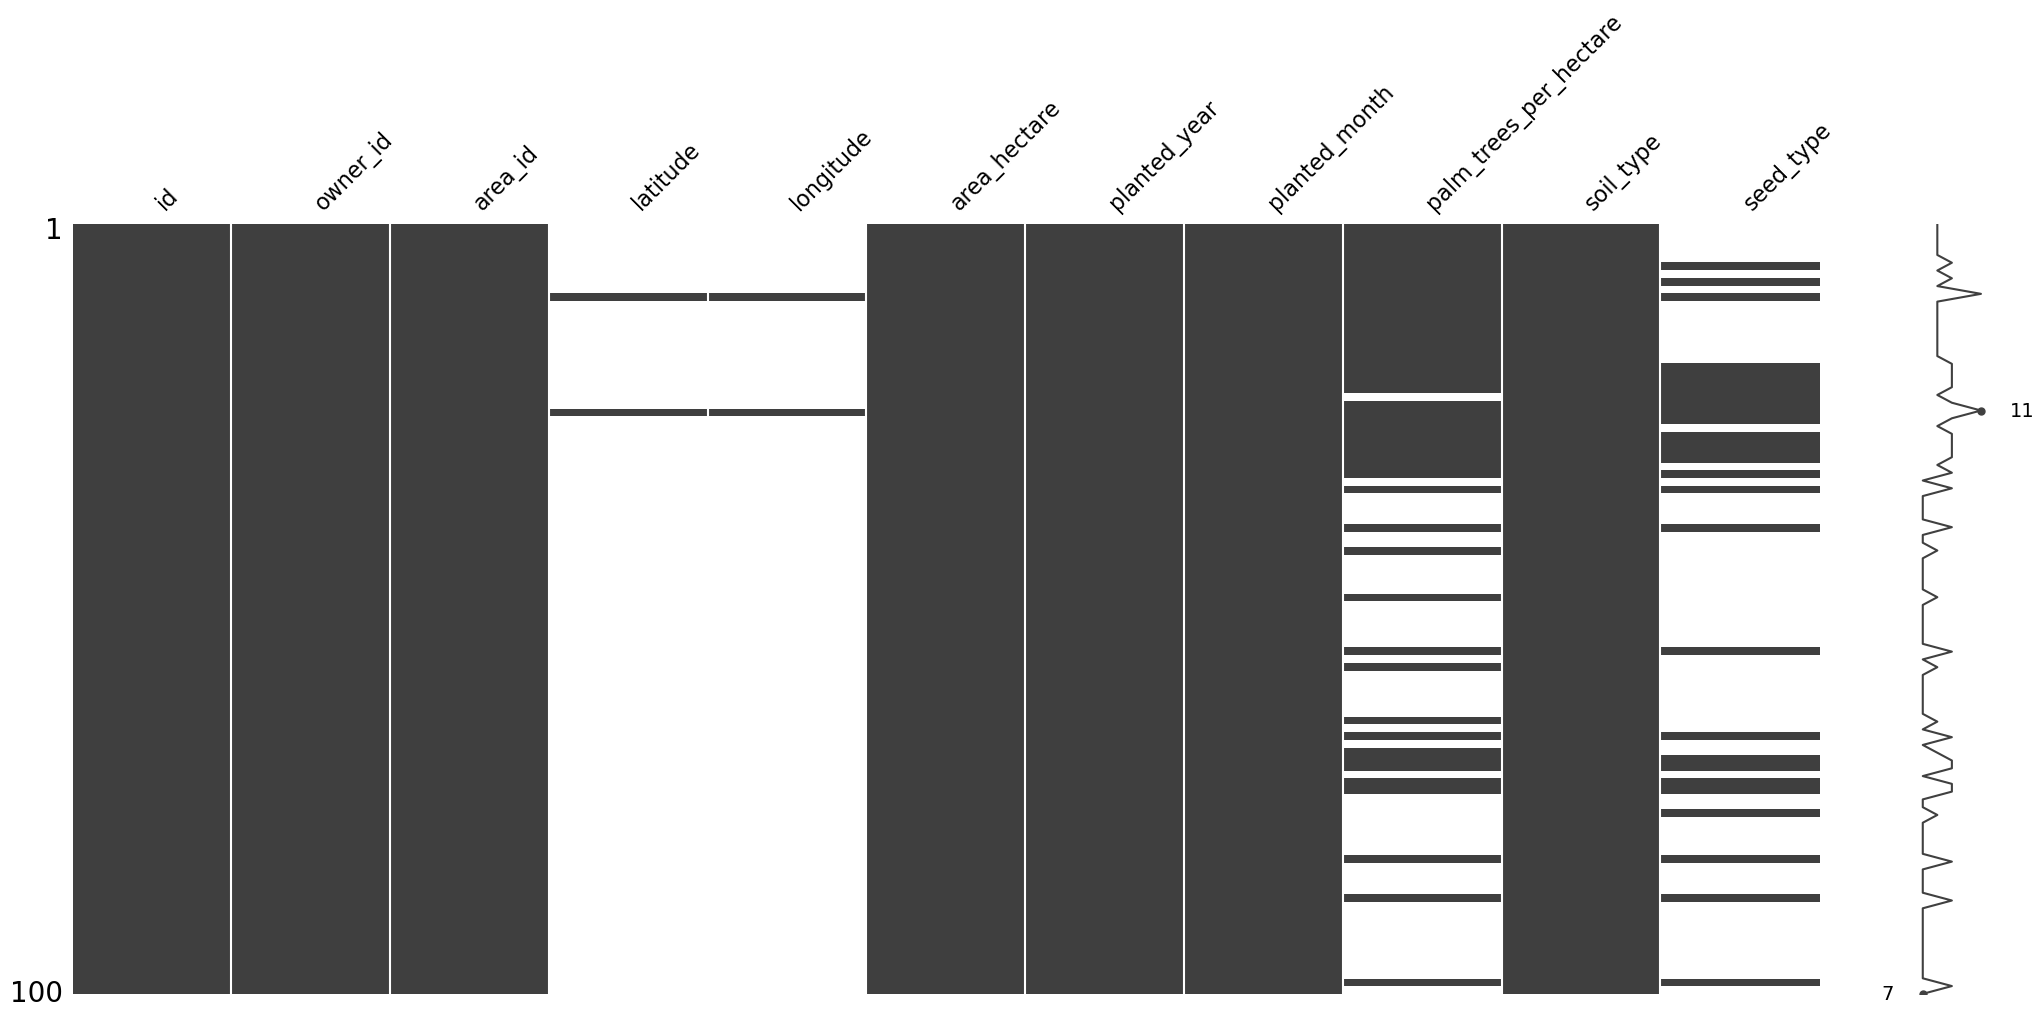

In [527]:
# show which rows contain missing values 
msno.matrix(farm_df)
plt.show()

In [528]:
# show null values in the product_df DataFrame
product_df.isnull().sum()

id                     0
sku                    0
type                   0
unit_of_measurement    0
name                   0
price                  0
description            0
dtype: int64

In [529]:
# show null values in the so_df DataFrame
so_df.isnull().sum()

id                  0
user_id             0
total_item_price    0
created_at_utc0     0
dtype: int64

In [530]:
# show null values in the soi_df DataFrame
soi_df.isnull().sum()

id                               0
sale_order_id                    0
product_id                       0
quantity                         0
price                            0
clicked_from_recommendation      0
click_timestamp                116
dtype: int64

In [531]:
# show null values in the feedback_df DataFrame
feedback_df.isnull().sum()

feedback_id       0
sales_order_id    0
rating            0
comment           0
dtype: int64

In [532]:
# show null values in the product_clicks_df DataFrame
product_clicks_df.isnull().sum()

prodct_clicks_id    0
product_id          0
timestamp           0
dtype: int64

In [533]:
# show null values in the user_session_df DataFrame
user_session_df.isnull().sum()

user_session_id    0
user_id            0
session_start      0
session_end        0
dtype: int64

In [534]:
# show the cardinality of the area_df DataFrame
area_df.nunique()

id                   46
name                 46
level_0               1
level_1              12
level_2              27
level_3              35
level_3_latitude     35
level_3_longitude    34
level_4              46
level_4_latitude     46
level_4_longitude    45
dtype: int64

In [535]:
# show the cardinality of the farm_df DataFrame
farm_df.nunique()

id                        100
owner_id                   97
area_id                    46
latitude                    2
longitude                   2
area_hectare               21
planted_year               21
planted_month              12
palm_trees_per_hectare     18
soil_type                   3
seed_type                  10
dtype: int64

In [536]:
# show the cardinality of the product_df DataFrame
product_df.nunique()

id                     41
sku                    41
type                    3
unit_of_measurement     2
name                   41
price                  41
description            40
dtype: int64

In [537]:
# show the cardinality of the so_df DataFrame
so_df.nunique()

id                  100
user_id              73
total_item_price     89
created_at_utc0     100
dtype: int64

In [538]:
# show the cardinality of the soi_df DataFrame
soi_df.nunique()

id                             116
sale_order_id                  100
product_id                      41
quantity                        31
price                           94
clicked_from_recommendation      1
click_timestamp                  0
dtype: int64

In [539]:
# show the cardinality of the feedback_df DataFrame
feedback_df.nunique()

feedback_id       41
sales_order_id    38
rating             5
comment           41
dtype: int64

In [540]:
# show the cardinality of the product_clicks_df DataFrame
product_clicks_df.nunique()

prodct_clicks_id    41
product_id          41
timestamp           41
dtype: int64

In [541]:
# show the cardinality of the user_session_df DataFrame
user_session_df.nunique()

user_session_id    41
user_id            35
session_start      41
session_end        41
dtype: int64

In [542]:
# check duplicates in the area_df DataFrame
area_df.duplicated().sum()  

0

In [543]:
# check duplicates in the farm_df DataFrame
farm_df.duplicated().sum()  

0

In [544]:
# check duplicates in the product_df DataFrame
product_df.duplicated().sum()

0

In [545]:
# check duplicates in the so_df DataFrame
so_df.duplicated().sum()

0

In [546]:
# check duplicates in the soi_df DataFrame  
soi_df.duplicated().sum()

0

In [547]:
# check duplicates in the feedback_df DataFrame
feedback_df.duplicated().sum()

0

In [548]:
# check duplicates in the product_clicks_df DataFrame
product_clicks_df.duplicated().sum()

0

In [549]:
# check duplicates in the user_session_df DataFrame
user_session_df.duplicated().sum()

0

### There are no duplicated rows for each table.

array([[<Axes: title={'center': 'level_3_latitude'}>,
        <Axes: title={'center': 'level_3_longitude'}>],
       [<Axes: title={'center': 'level_4_latitude'}>,
        <Axes: title={'center': 'level_4_longitude'}>]], dtype=object)

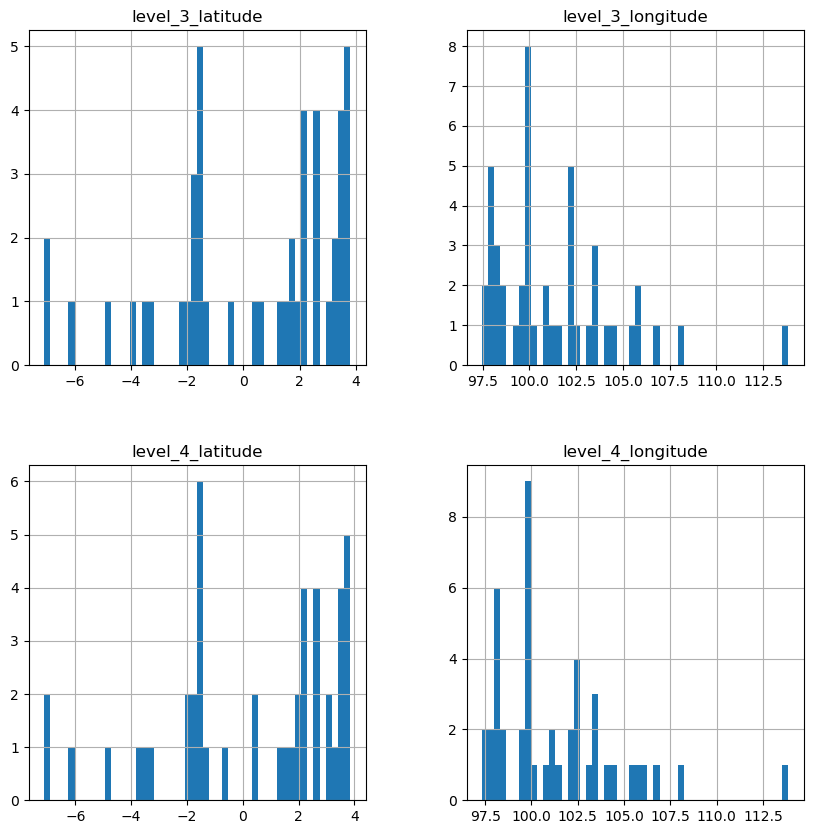

In [550]:
# plot histogram of the area_df DataFrame
area_df.hist(figsize=(10, 10), bins=50)

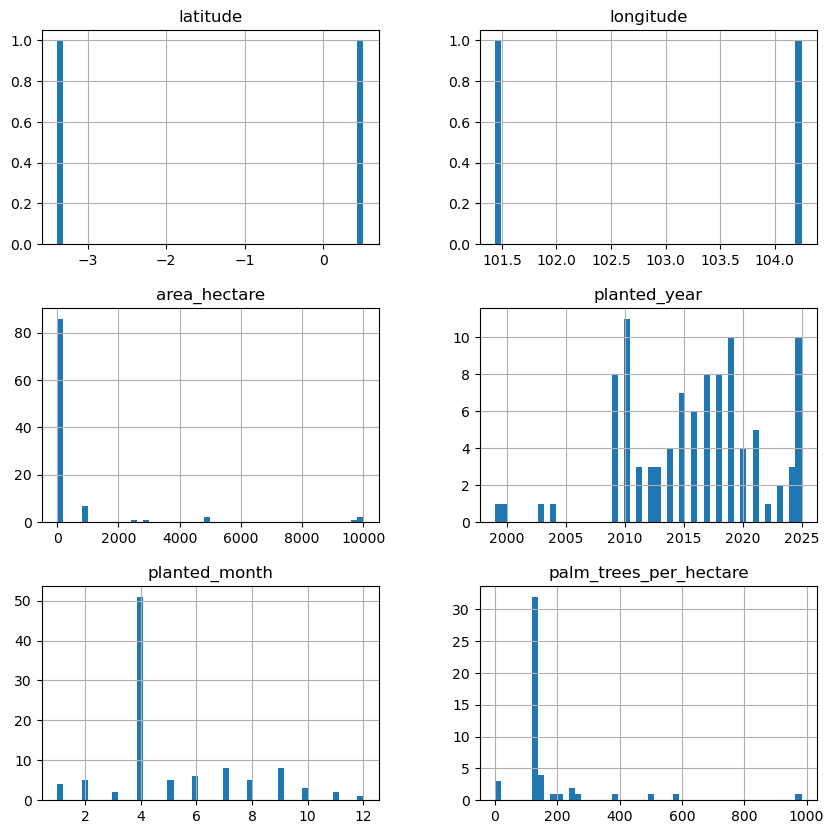

In [551]:
# plot histogram of the farm_df DataFrame
farm_df.hist(figsize=(10, 10), bins=50)
plt.show()

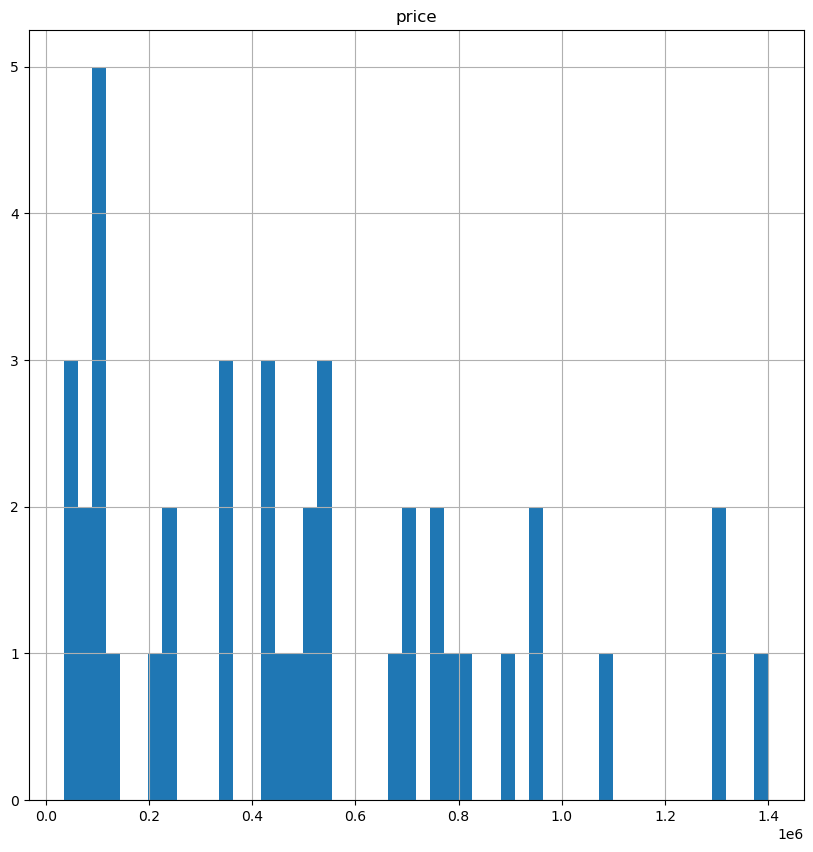

In [552]:
# plot histogram of the product_df DataFrame
product_df.hist(figsize=(10, 10), bins=50)
plt.show()

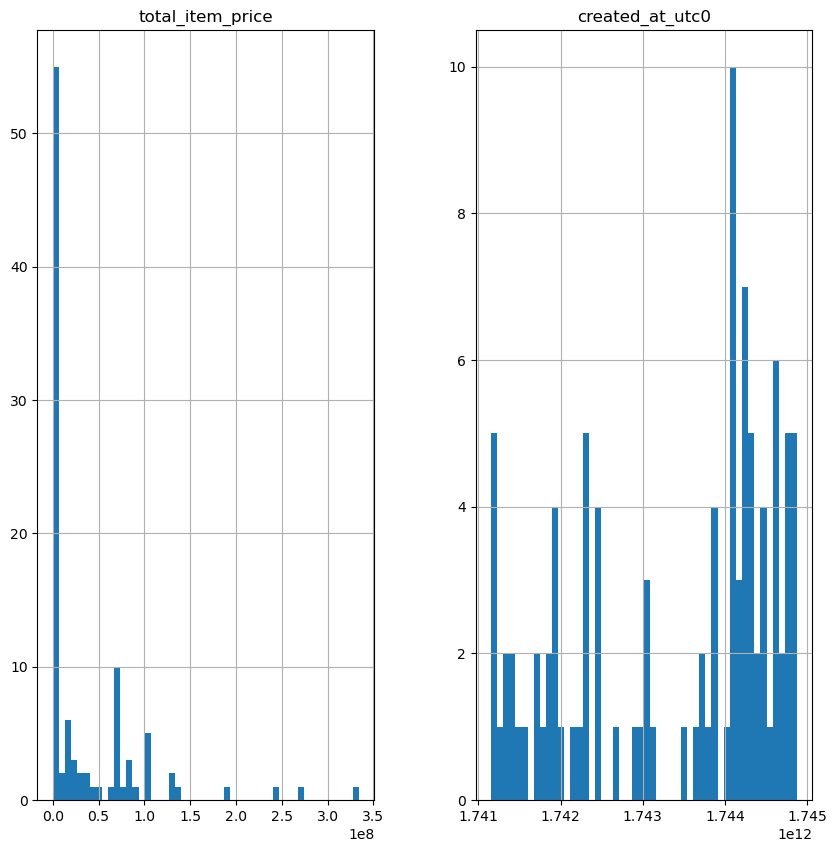

In [553]:
# plot histogram of the so_df DataFrame
so_df.hist(figsize=(10, 10), bins=50)
plt.show()

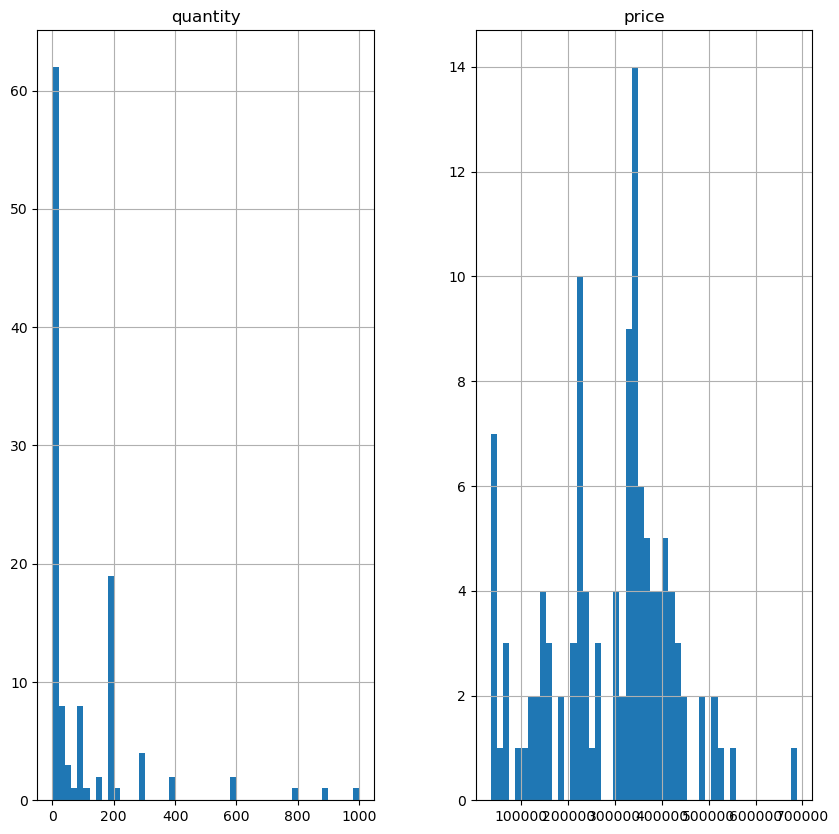

In [554]:
# plot histogram of the soi_df DataFrame
soi_df.hist(figsize=(10, 10), bins=50)
plt.show()

### Renaming of columns for easier interpretability

In [555]:
area_df.columns

Index(['id', 'name', 'level_0', 'level_1', 'level_2', 'level_3',
       'level_3_latitude', 'level_3_longitude', 'level_4', 'level_4_latitude',
       'level_4_longitude'],
      dtype='object')

In [556]:
farm_df.columns

Index(['id', 'owner_id', 'area_id', 'latitude', 'longitude', 'area_hectare',
       'planted_year', 'planted_month', 'palm_trees_per_hectare', 'soil_type',
       'seed_type'],
      dtype='object')

In [557]:
soi_df.columns

Index(['id', 'sale_order_id', 'product_id', 'quantity', 'price',
       'clicked_from_recommendation', 'click_timestamp'],
      dtype='object')

In [558]:
so_df.columns

Index(['id', 'user_id', 'total_item_price', 'created_at_utc0'], dtype='object')

In [559]:
product_df.columns

Index(['id', 'sku', 'type', 'unit_of_measurement', 'name', 'price',
       'description'],
      dtype='object')

In [560]:
# rename area_df columns
area_df.rename(columns={'id': 'area_id'}, inplace=True)
area_df.columns

Index(['area_id', 'name', 'level_0', 'level_1', 'level_2', 'level_3',
       'level_3_latitude', 'level_3_longitude', 'level_4', 'level_4_latitude',
       'level_4_longitude'],
      dtype='object')

In [561]:
# rename farm_df columns
farm_df.rename(columns={'id': 'farm_id'}, inplace=True)
farm_df.columns

Index(['farm_id', 'owner_id', 'area_id', 'latitude', 'longitude',
       'area_hectare', 'planted_year', 'planted_month',
       'palm_trees_per_hectare', 'soil_type', 'seed_type'],
      dtype='object')

In [562]:
# rename product_df columns
product_df.rename(columns={'id': 'product_id', 'price': 'product_price'}, inplace=True)
product_df.columns

Index(['product_id', 'sku', 'type', 'unit_of_measurement', 'name',
       'product_price', 'description'],
      dtype='object')

In [563]:
# rename soi_df columns
soi_df.rename(columns={'id': 'sale_order_item_id', 'price': 'sale_order_item_price'}, inplace=True)
soi_df.columns

Index(['sale_order_item_id', 'sale_order_id', 'product_id', 'quantity',
       'sale_order_item_price', 'clicked_from_recommendation',
       'click_timestamp'],
      dtype='object')

In [564]:
# rename so_df columns
so_df.rename(columns={'id': 'sale_order_id'}, inplace=True)
so_df.columns

Index(['sale_order_id', 'user_id', 'total_item_price', 'created_at_utc0'], dtype='object')

In [565]:
# Convert from milliseconds to datetime
so_df['created_at'] = pd.to_datetime(so_df['created_at_utc0'], unit='ms')
so_df.head()

,sale_order_id,user_id,total_item_price,created_at_utc0,created_at
0,74be876e-f74b-4633-b403-e07fa9861943,9c605d36-9c37-4f1e-bac1-c87146fae1f0,102000000.0,1744879059936,2025-04-17 08:37:39.936
1,911a4c25-75d1-4f67-9a8a-40cb365b4cf0,49ad56f8-8d32-408f-9f88-36cad5310680,433200.0,1744875110464,2025-04-17 07:31:50.464
2,e5819416-6b56-4337-9271-dc2c701ac7bd,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,2025-04-17 07:23:18.061
3,61e68625-9e6a-435d-9bdd-6c2187ca1817,49ad56f8-8d32-408f-9f88-36cad5310680,433200.0,1744868860328,2025-04-17 05:47:40.328
4,667698fd-6694-4b97-b7f3-e993f1cd7756,231e825c-16af-4695-bda8-91deb60777e5,50000.0,1744859221323,2025-04-17 03:07:01.323


In [566]:
# minmax date of created_at
so_df['created_at'].min(), so_df['created_at'].max()

(Timestamp('2025-03-05 05:02:26.062000'),
 Timestamp('2025-04-17 08:37:39.936000'))

### View cardinality of level variables 

In [567]:
# show values for area_df for level variables
area_df['level_1'].value_counts()

level_1
Sumatera Utara               20
Jambi                         9
Aceh                          4
Riau                          3
Sumatera Selatan              2
Kepulauan Bangka Belitung     2
Sumatera Barat                1
Bengkulu                      1
Lampung                       1
Dki Jakarta                   1
Jawa Barat                    1
Jawa Timur                    1
Name: count, dtype: int64

In [568]:
area_df['level_2'].value_counts()

level_2
Langkat                    7
Labuhan Batu Utara         5
Bungo                      4
Aceh Selatan               2
Asahan                     2
Bangka                     2
Labuhan Batu Selatan       2
Aceh Tenggara              2
Muaro Jambi                2
Sumedang                   1
Kota Adm. Jakarta Barat    1
Lampung Tengah             1
Bengkulu Tengah            1
Kota Prabumulih            1
Ogan Komering Ulu          1
Tebo                       1
Kota Pekanbaru             1
Tanjung Jabung Timur       1
Batang Hari                1
Rokan Hilir                1
Kampar                     1
Sijunjung                  1
Labuhanbatu Utara          1
Padang Lawas Utara         1
Labuhan Batu               1
Deli Serdang               1
Sumenep                    1
Name: count, dtype: int64

In [569]:
area_df['level_3'].value_counts()

level_3
Marbau                     4
Pelepat Ilir               3
Bahorok                    3
Sawit Seberang             3
Jambi Luar Kota            2
Silangkitang               2
Kedaton Peninjauan Raya    1
Mendahara Ulu              1
Bungo Dani                 1
Tebo Tengah                1
Kluet Selatan              1
Cambai                     1
Muara Tembesi              1
Seputih Banyak             1
Mendo Barat                1
Puding Besar               1
Kebon Jeruk                1
Wado                       1
Pematang Tiga              1
Kampa                      1
Limapuluh                  1
Rantau Kopar               1
Kluet Timur                1
Sumpur Kudus               1
Kualuh Hilir               1
Kualuh Hulu                1
Simangambat                1
Bilah Hulu                 1
Aek Songsongan             1
Aek Kuasan                 1
Hamparan Perak             1
Binjai                     1
Bambel                     1
Lawe Sigala-Gala           1
Sarong

In [570]:
area_df['level_4'].value_counts()

level_4
Ujung Pasir             1
Kuning Gading           1
Pulau Birandang         1
Rantau Kopar            1
Tanjung Rhu             1
Pasar Muara Tembesi     1
Pijoan                  1
Mendalo Darat           1
Simpang Tuan            1
Daya Murni              1
Tirta Mulia             1
Sungai Pinang           1
Pucuk Lembang           1
Muara Tebo              1
Bunglai                 1
Muara Sungai            1
Senabah                 1
Setia Bumi              1
Kemuja                  1
Tanah Bawah             1
Kebon Jeruk             1
Wado                    1
Sisawah                 1
Sumber Mulyo            1
Belongkut               1
Sipare Pare Tengah      1
Suka Maju               1
Terutung Seperai        1
Lau Damak               1
Timbang Lawan           1
Simpang Pulo Rambung    1
Sukamakmur              1
Sawit Seberang          1
Sawit Hulu              1
Mekar Sawit             1
Kota Datar              1
Rawa Sari               1
Lobu Rappa              1
Ling

### Merging of Dataframes

In [571]:
merged_data = soi_df.merge(so_df, on='sale_order_id')
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,created_at
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200,326000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,2025-04-08 02:19:58.583
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,2025-04-08 02:19:58.583
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,None,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,2025-04-09 07:03:22.966
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,None,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,2025-03-20 02:45:12.361
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,None,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,2025-04-17 07:23:18.061


In [572]:
merged_data = merged_data.merge(product_df, on='product_id')
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,created_at,sku,type,unit_of_measurement,name,product_price,description
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200,326000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,2025-04-08 02:19:58.583,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. <p><strong><em><u>Deskripsi</u></em></strong></p><p><br></p><p>Pupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.</p><p><br></p><p><strong><em><u>Manfaat </u></em></strong></p><p>Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.</p><p><br></p><p><strong><em><u>Kandungan dan Spesifikasi </u></em></strong></p><p><br></p><p>Kalium oksida 60%</p><p>Bentuk / Warna: Kristal / Dominan merah</p><p><br></p><p><strong><em><u>Produk Teruji Lab?</u> </em></strong>Ya</p>"
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,2025-04-08 02:19:58.583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. <p><strong>Deskripsi</strong></p><p><br></p><p>Pupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.</p><p><br></p><p><strong>Manfaat</strong></p><p><br></p><p>Memberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.</p><p><br></p><p><strong>Kandungan dan Spesifikasi</strong></p><p><br></p><p>Fosfor pentoksida 26-28%</p><p><br></p><p><strong>Produk Teruji Lab?</strong> Ya</p>"
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,None,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,2025-04-09 07:03:22.966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,None,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,2025-03-20 02:45:12.361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"<p>Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".</p><p>Ukuran All-size (XL)</p>"
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,None,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,2025-04-17 07:23:18.061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. <p><strong><em><u>Deskripsi</u></em></strong></p><p><br></p><p>Pupuk MOP/KCL Ma

In [573]:
def clean_html(raw_html):
    # Remove HTML tags
    clean_text = re.sub(r'<[^>]+>', '', raw_html)
    # Remove leading/trailing whitespaces and normalize spaces
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    return clean_text

# Apply to the 'description' column
merged_data['description'] = merged_data['description'].astype(str).apply(clean_html)

# Preview the cleaned descriptions
merged_data[['description']].head()


,description
0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"
1,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya"
2,Topup PLN 100.000 Topup PLN 100.000
3,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)"
4,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"


In [574]:
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,created_at,sku,type,unit_of_measurement,name,product_price,description
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200,326000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,2025-04-08 02:19:58.583,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,2025-04-08 02:19:58.583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya"
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,None,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,2025-04-09 07:03:22.966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,None,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,2025-03-20 02:45:12.361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)"
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,None,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,2025-04-17 07:23:18.061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentuk

In [575]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   sale_order_item_id           116 non-null    object        
 1   sale_order_id                116 non-null    object        
 2   product_id                   116 non-null    object        
 3   quantity                     116 non-null    int64         
 4   sale_order_item_price        116 non-null    float64       
 5   clicked_from_recommendation  116 non-null    bool          
 6   click_timestamp              0 non-null      object        
 7   user_id                      116 non-null    object        
 8   total_item_price             116 non-null    float64       
 9   created_at_utc0              116 non-null    int64         
 10  created_at                   116 non-null    datetime64[ns]
 11  sku                          116 non-null    

## Association Rule

In [576]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import LabelEncoder

In [577]:
# define season type in indonesia
from datetime import datetime

def month_to_season(month):
    if month in [10, 11, 12, 1, 2, 3]:
        return 'wet_season'
    else:
        return 'dry_season'

merged_data['created_at'] = pd.to_datetime(merged_data['created_at_utc0'], unit='ms')
merged_data['season'] = merged_data['created_at'].dt.month.apply(month_to_season)
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,created_at,sku,type,unit_of_measurement,name,product_price,description,season
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200,326000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,2025-04-08 02:19:58.583,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya",dry_season
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,2025-04-08 02:19:58.583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya",dry_season
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,None,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,2025-04-09 07:03:22.966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000,dry_season
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,None,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,2025-03-20 02:45:12.361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)",wet_season
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,None,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,2025-04-17 07:23:18.061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya taha

In [578]:
# Sum total_item_price per product per season
seasonal_sales = (
    merged_data
    .groupby(['season', 'product_id'])['total_item_price']
    .sum()
    .reset_index()
    .rename(columns={'total_item_price': 'season_sales'})
)


In [579]:
# Get average sales per product within each season
season_avg = seasonal_sales.groupby('season')['season_sales'].mean().to_dict()

# Calculate boost = product's sales / average sales that season
seasonal_sales['boost'] = seasonal_sales.apply(
    lambda row: row['season_sales'] / season_avg[row['season']], axis=1
)


In [591]:
seasonal_boost = (
    seasonal_sales
    .groupby('season')
    .apply(lambda df: dict(zip(df['product_id'], df['boost'])))
    .to_dict()
)
print(seasonal_boost)

{'dry_season': {'1af0394e-3aea-42b4-8698-b6832e35f8ce': 0.0020966041870326044, '4cac8d01-b78e-4017-9113-c627ac1866a5': 6.15002595851629, '5952d124-7dc6-4a6a-baa2-e2e502ecd6fe': 0.000849553369466743, '6c27fc9c-e7e9-4e9b-9017-292175250df1': 0.006752780177119139, '6eccf249-a997-4091-8d64-29f1e9accd85': 0.0022318312600624023, '701928af-24e9-4a13-aaad-63ede44be9c8': 0.0020998153428878363, '80957603-6cec-4f63-8dcd-aba6ded5cbdd': 9.561516630556532, '8152e395-0f7a-4dda-8df9-6655a726c4e1': 0.22414179632224399, '8acff85f-f70a-4308-801f-763b22bb25c7': 0.6270327392073346, '8fcfd7a8-5980-4e7e-b463-6d30823caac4': 0.12189921741706294, '944f4171-813b-4423-ad89-3c73d67f9986': 0.010112802723698156, 'a48adaed-ab06-4245-8da6-5d560636a1d9': 0.18597035020331396, 'b53ce31c-3789-42d7-96a0-5fe058cac7a5': 0.7240513442970562, 'b67588d2-e8fe-4ee4-9931-e9d18241d04c': 0.015868721653525583, 'beb17fe4-5d92-4738-adaa-2d62ffb83516': 3.1659502630953305, 'c1d06ac3-5bea-4b4d-8648-ae3fa531f059': 0.00038970338048933164, 'c2

C:\Users\user\AppData\Local\Temp\ipykernel_20448\1471582812.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: dict(zip(df['product_id'], df['boost'])))


In [581]:
current_season = month_to_season(datetime.now().month)
season_multiplier = seasonal_boost.get(current_season, {}).get(product_id, 1.0)


In [582]:
# Use only the current season
current_season = month_to_season(datetime.now().month)
season_data = merged_data[merged_data['season'] == current_season]

# Create a basket matrix (user x product) where each entry is 1 if the user purchased the product, 0 otherwise
basket = merged_data.groupby(['user_id', 'product_id'])['quantity'].sum().unstack().fillna(0)

# Convert quantities to binary format: 1 if product was purchased, 0 if not
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
basket.head()   

C:\Users\user\AppData\Local\Temp\ipykernel_20448\1414791051.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


product_id,0bd2430a-6613-442a-9d5a-11d64cb095ae,1033503b-8faa-4d5c-97c2-50bb19fbb897,1af0394e-3aea-42b4-8698-b6832e35f8ce,2485b082-5258-44c1-b6aa-983387d540a7,2b8fe2f0-5d07-459c-8781-22305a61980a,369cfbc5-f536-41f5-8a80-267d55dec802,4698d965-a133-4701-838b-f60e38c66b39,487f2886-5150-4269-94e2-63fbc7314971,4cac8d01-b78e-4017-9113-c627ac1866a5,5110ed03-9e1e-44bd-913c-4f56de2dcf0b,5501ce77-7a08-4086-8dda-858c92326fc6,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,6c27fc9c-e7e9-4e9b-9017-292175250df1,6eccf249-a997-4091-8d64-29f1e9accd85,701928af-24e9-4a13-aaad-63ede44be9c8,76fddc47-aea9-4942-9dbd-19d90f31cdd4,80957603-6cec-4f63-8dcd-aba6ded5cbdd,8152e395-0f7a-4dda-8df9-6655a726c4e1,89f26d03-4933-4924-ae31-5eef6981122f,8acff85f-f70a-4308-801f-763b22bb25c7,8df8c2e5-5ad8-490f-83b2-57fa0c961f84,8fcfd7a8-5980-4e7e-b463-6d30823caac4,944f4171-813b-4423-ad89-3c73d67f9986,9e7cc609-f4ef-4246-89e7-756861e623d8,a48adaed-ab06-4245-8da6-5d560636a1d9,af58006e-c0d7-44ec-9089-609b74e9ece2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,b67588d2-e8fe-4ee4-9931-e9d18241d04c,beb17fe4-5d92-4738-adaa-2d62ffb83516,c1d06ac3-5bea-4b4d-8648-ae3fa531f059,c2b3d62f-6c48-4051-beb1-3ec66d30c1da,c5e57af4-0df9-4e2b-87e4-9024b8e6cf53,c7768e6d-d8d9-469f-960d-879b5401d83c,d3999f4e-890a-473f-bb92-2fd2178da3fb,d8232157-edeb-4ac8-ba5a-0cf53e3c8a06,e41e1522-bbe0-4e9b-b638-5470e82e13a5,e8898291-543b-439c-907f-bd80075f02a0,ece9fda2-1006-4cf9-a283-74e10b330512,ecef7b49-b297-4c53-bf53-628861221da7,fc02857f-92ea-48a1-96b5-95acf43b922e,ff58b8c4-1058-4753-bfc0-c04d091c8485
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02b2724f-0227-4c94-a7a0-8cf37f7aee70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
05dfbe78-f1f3-486d-8bc8-91ef41b3ae78,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
05ebeca1-5a73-46ec-88fc-323b29d468cc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0600fab5-173c-4333-b3c3-c18b37148acf,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0baaaa63-a05f-492d-8f87-9532257d85f9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [583]:
basket.shape

(73, 41)

In [584]:
# Apply the Apriori algorithm to find frequent itemsets
# min_support=0.01 means only include itemsets purchased by at least 1% of all users
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Display the top 10 most frequent itemsets, sorted by support
frequent_itemsets.sort_values(by="support", ascending=False).head(10)

c:\Users\user\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
16,0.178082,(80957603-6cec-4f63-8dcd-aba6ded5cbdd)
8,0.136986,(4cac8d01-b78e-4017-9113-c627ac1866a5)
26,0.095890,(b53ce31c-3789-42d7-96a0-5fe058cac7a5)
6,0.082192,(4698d965-a133-4701-838b-f60e38c66b39)
17,0.082192,(8152e395-0f7a-4dda-8df9-6655a726c4e1)
19,0.054795,(8acff85f-f70a-4308-801f-763b22bb25c7)
37,0.054795,(ece9fda2-1006-4cf9-a283-74e10b330512)
30,0.054795,(c2b3d62f-6c48-4051-beb1-3ec66d30c1da)
24,0.054795,(a48adaed-ab06-4245-8da6-5d560636a1d9)
38,0.054795,(ecef7b49-b297-4c53-bf53-628861221da7)


apriori identifies all combinations of products (itemsets) that occur together in at least 1% of user transactions (min_support=0.01).

The resulting frequent_itemsets DataFrame includes:

* support: the proportion of users who purchased the itemset.
* itemsets: the combination of items that appear together frequently.

Sorting by support helps identify the most commonly co-purchased products.

In [585]:
frequent_itemsets.shape

(200, 2)

In [586]:
# Generate association rules from the frequent itemsets
# metric="confidence" specifies that rules must meet a minimum confidence level
# min_threshold=0.1 means only include rules where the confidence is at least 10%
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Display top 10 strongest rules based on lift
rules[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
1012,"(c2b3d62f-6c48-4051-beb1-3ec66d30c1da, 1033503b-8faa-4d5c-97c2-50bb19fbb897, b53ce31c-3789-42d7-96a0-5fe058cac7a5)","(1af0394e-3aea-42b4-8698-b6832e35f8ce, 369cfbc5-f536-41f5-8a80-267d55dec802)",0.013699,0.013699,0.013699,1.0,73.0
867,"(a48adaed-ab06-4245-8da6-5d560636a1d9, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, 369cfbc5-f536-41f5-8a80-267d55dec802)","(1af0394e-3aea-42b4-8698-b6832e35f8ce, 1033503b-8faa-4d5c-97c2-50bb19fbb897)",0.013699,0.013699,0.013699,1.0,73.0
950,"(1033503b-8faa-4d5c-97c2-50bb19fbb897, b53ce31c-3789-42d7-96a0-5fe058cac7a5, 369cfbc5-f536-41f5-8a80-267d55dec802)","(1af0394e-3aea-42b4-8698-b6832e35f8ce, a48adaed-ab06-4245-8da6-5d560636a1d9)",0.013699,0.013699,0.013699,1.0,73.0
949,"(1af0394e-3aea-42b4-8698-b6832e35f8ce, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 369cfbc5-f536-41f5-8a80-267d55dec802)","(b53ce31c-3789-42d7-96a0-5fe058cac7a5, a48adaed-ab06-4245-8da6-5d560636a1d9)",0.013699,0.013699,0.013699,1.0,73.0
948,"(1033503b-8faa-4d5c-97c2-50bb19fbb897, a48adaed-ab06-4245-8da6-5d560636a1d9, 369cfbc5-f536-41f5-8a80-267d55dec802)","(1af0394e-3aea-42b4-8698-b6832e35f8ce, b53ce31c-3789-42d7-96a0-5fe058cac7a5)",0.013699,0.013699,0.013699,1.0,73.0
946,"(1af0394e-3aea-42b4-8698-b6832e35f8ce, b53ce31c-3789-42d7-96a0-5fe058cac7a5, 1033503b-8faa-4d5c-97c2-50bb19fbb897, a48adaed-ab06-4245-8da6-5d560636a1d9)",(369cfbc5-f536-41f5-8a80-267d55dec802),0.013699,0.013699,0.013699,1.0,73.0
940,(369cfbc5-f536-41f5-8a80-267d55dec802),"(1af0394e-3aea-42b4-8698-b6832e35f8ce, c2b3d62f-6c48-4051-beb1-3ec66d30c1da, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 80957603-6cec-4f63-8dcd-aba6ded5cbdd)",0.013699,0.013699,0.013699,1.0,73.0
938,"(1af0394e-3aea-42b4-8698-b6832e35f8ce, c2b3d62f-6c48-4051-beb1-3ec66d30c1da)","(1033503b-8faa-4d5c-97c2-50bb19fbb897, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, 369cfbc5-f536-41f5-8a80-267d55dec802)",0.013699,0.013699,0.013699,1.0,73.0
937,"(1af0394e-3aea-42b4-8698-b6832e35f8ce, 369cfbc5-f536-41f5-8a80-267d55dec802)","(c2b3d62f-6c48-4051-beb1-3ec66d30c1da, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 80957603-6cec-4f63-8dcd-aba6ded5cbdd)",0.013699,0.013699,0.013699,1.0,73.0
936,"(c2b3d62f-6c48-4051-beb1-3ec66d30c1da, 369cfbc5-f536-41f5-8a80-267d55dec802)","(1af0394e-3aea-42b4-8698-b6832e35f8ce, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 80957603-6cec-4f63-8dcd-aba6ded5cbdd)",0.013699,0.013699,0.013699,1.0,73.0


**Confidence** measures how likely the consequent is purchased when the antecedent is purchased.

**Lift** shows the strength of a rule over random co-occurrence. A lift > 1 indicates a positive association.

The result is sorted by lift to show the most impactful rules.

In [587]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

rules[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).tail(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
274,"(a48adaed-ab06-4245-8da6-5d560636a1d9, 80957603-6cec-4f63-8dcd-aba6ded5cbdd)",(4cac8d01-b78e-4017-9113-c627ac1866a5),0.041096,0.136986,0.013699,0.333333,2.433333
48,(6c27fc9c-e7e9-4e9b-9017-292175250df1),(80957603-6cec-4f63-8dcd-aba6ded5cbdd),0.041096,0.178082,0.013699,0.333333,1.871795
38,(4cac8d01-b78e-4017-9113-c627ac1866a5),(a48adaed-ab06-4245-8da6-5d560636a1d9),0.136986,0.054795,0.013699,0.100000,1.825000
39,(a48adaed-ab06-4245-8da6-5d560636a1d9),(4cac8d01-b78e-4017-9113-c627ac1866a5),0.054795,0.136986,0.013699,0.250000,1.825000
35,(80957603-6cec-4f63-8dcd-aba6ded5cbdd),(4cac8d01-b78e-4017-9113-c627ac1866a5),0.178082,0.136986,0.041096,0.230769,1.684615
34,(4cac8d01-b78e-4017-9113-c627ac1866a5),(80957603-6cec-4f63-8dcd-aba6ded5cbdd),0.136986,0.178082,0.041096,0.300000,1.684615
58,(80957603-6cec-4f63-8dcd-aba6ded5cbdd),(b53ce31c-3789-42d7-96a0-5fe058cac7a5),0.178082,0.095890,0.027397,0.153846,1.604396
57,(b53ce31c-3789-42d7-96a0-5fe058cac7a5),(80957603-6cec-4f63-8dcd-aba6ded5cbdd),0.095890,0.178082,0.027397,0.285714,1.604396
63,(ecef7b49-b297-4c53-bf53-628861221da7),(80957603-6cec-4f63-8dcd-aba6ded5cbdd),0.054795,0.178082,0.013699,0.250000,1.403846
59,(c2b3d62f-6c48-4051-beb1-3ec66d30c1da),(80957603-6cec-4f63-8dcd-aba6ded5cbdd),0.054795,0.178082,0.013699,0.250000,1.403846


The result is sorted by lift to show the least impactful rules.

In [588]:
rules.shape

(2024, 14)

In [589]:
# Define the user
user_id = '13f5223e-f04a-4fa8-9ef2-cf36060f0d6d'

# Products user bought in this season
user_products = season_data[season_data['user_id'] == user_id]['product_id'].unique()

recommendation_dict = {}

for pid in user_products:
    related_rules = rules[rules['antecedents'].apply(lambda x: pid in x)]
    for _, row in related_rules.iterrows():
        for consequent in row['consequents']:
            if consequent not in user_products:
                if consequent not in recommendation_dict or row['lift'] > recommendation_dict[consequent]:
                    recommendation_dict[consequent] = row['lift']

# Sort by lift
sorted_recommendations = sorted(recommendation_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Display
for product_id, lift in sorted_recommendations:
    product_name = merged_data.loc[merged_data['product_id'] == product_id, 'name'].dropna().unique()
    product_name = product_name[0] if len(product_name) > 0 else "Unknown Product"
    print(f"{product_name} (Product ID: {product_id}) - Lift: {lift:.2f}")


TSP China Cap Daun 50kg (Product ID: 1033503b-8faa-4d5c-97c2-50bb19fbb897) - Lift: 73.00
Urea Nitrea 46% N 50kg (Product ID: 4cac8d01-b78e-4017-9113-c627ac1866a5) - Lift: 73.00
Borate Mahkota - 25kg (Product ID: a48adaed-ab06-4245-8da6-5d560636a1d9) - Lift: 73.00
Petro ZA Plus 50kg (Product ID: 1af0394e-3aea-42b4-8698-b6832e35f8ce) - Lift: 73.00
Kieserite SoluMAG-G 50kg (Product ID: 369cfbc5-f536-41f5-8a80-267d55dec802) - Lift: 73.00
RP Cap Daun 50Kg (Product ID: c2b3d62f-6c48-4051-beb1-3ec66d30c1da) - Lift: 73.00
Meroke TSP 50kg (Product ID: e8898291-543b-439c-907f-bd80075f02a0) - Lift: 73.00
NPK Phonska Plus 15-15-15 25kg (Product ID: 6c27fc9c-e7e9-4e9b-9017-292175250df1) - Lift: 73.00
Pupuk SawitPRO 50kg (Product ID: ecef7b49-b297-4c53-bf53-628861221da7) - Lift: 73.00
NPK Mahkota 13-8-27-4 0.5 B 50kg (Product ID: ece9fda2-1006-4cf9-a283-74e10b330512) - Lift: 24.33


* support : items’ frequency of occurrence
* confidence : conditional probability of purchasing consequents Y when antecedents X is purchased
* lift : How many times the probability of purchasing consequents Y increases when antecedents X is purchased

(Ayman, 2022)

I used lift as my key metric because it shows how much more likely a product is bought together with another, helping to find the strongest and most meaningful associations.

In [590]:
# import joblib

# # Bundle all required components into a single object
# association_model = {
#     'frequent_itemsets': frequent_itemsets,
#     'rules': rules,
#     'basket': basket,
#     'data': merged_data
# }

# # Save the single model file
# joblib.dump(association_model, 'association_rule_model.pkl')
